# Annotations of artefacts

## Introduction

We will here show how artefacts can be identified and then annocated. The annotations will be represented in the fif data file. Sections or trials will not be rejected at this stage; rather the annotations may later be used. For instance the can be used to reject trials with eyeblinks or muscle contractions depending on the relevance for the analysis.  



## Preparation

Import the relevant modules: 

In [1]:
import os.path as op
import os
import sys
import numpy as np
from mne.preprocessing import annotate_muscle_zscore
import mne

Load the fif-files: 

In [2]:
# data_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\data'
# data_path = r'C:\Users\Ole\Dropbox\FLUX\Development\FLUX\data'
data_path = r'D:\FLUX\results'
file_name = ['training_rawsss-1.fif','training_rawsss-2.fif']
path_data = os.path.join(data_path,file_name[0]) 
result_path = r'D:\FLUX\results'
data1 = mne.io.read_raw_fif(path_data,preload=True)

Opening raw data file D:\FLUX\results\training_rawsss-1.fif...


<ipython-input-2-a023eff1ac8d>:7: RuntimeWarning: This filename (D:\FLUX\results\training_rawsss-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data1 = mne.io.read_raw_fif(path_data,preload=True)


    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...


## Identifying eye blinks

The artefacts associated with eye blinks are marked automatically. This is done on the basis of the vertical EOG channel (EOG001). The threshold for annonation is determined according to (max(hEOG) - min(hEOG))/4 following 1 - 10 Hz bandpass filtering. Segments being 500 ms long starting 250 ms prior to exceeding the threshold are annocated as blinks. 

In [3]:
eog_events = mne.preprocessing.find_eog_events(data1,ch_name = 'EOG001') 

n_blinks = len(eog_events)  
onset = eog_events[:, 0] / data1.info['sfreq'] - 0.25  
onset -= data1._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
annotations_blink = mne.Annotations(onset,duration,description)

Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 543 significant peaks
Number of EOG events detected: 543


## Finding muscle artefacts

Muscle artefact are identified from the magnetometer data filtered in the 110 - 140 Hz range. The data are subsequently z-scored if they exceed the value *threshold_muscle*. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.

In [4]:
data1filt = data1.copy().notch_filter([50, 100])

threshold_muscle = 10  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    data1, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 sec)



C:\ProgramData\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



## Include annotations in dataset and inspect

Now mark all the annotations in the data set: 

In [5]:
data1.set_annotations(annotations_blink+annotations_muscle)  

<ipython-input-5-505152a4396f>:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data1.set_annotations(annotations_blink+annotations_muscle)


<Raw | training_rawsss-1.fif, 343 x 1457000 (1457.0 s), ~3.73 GB, data loaded>

To inspect the annotations write

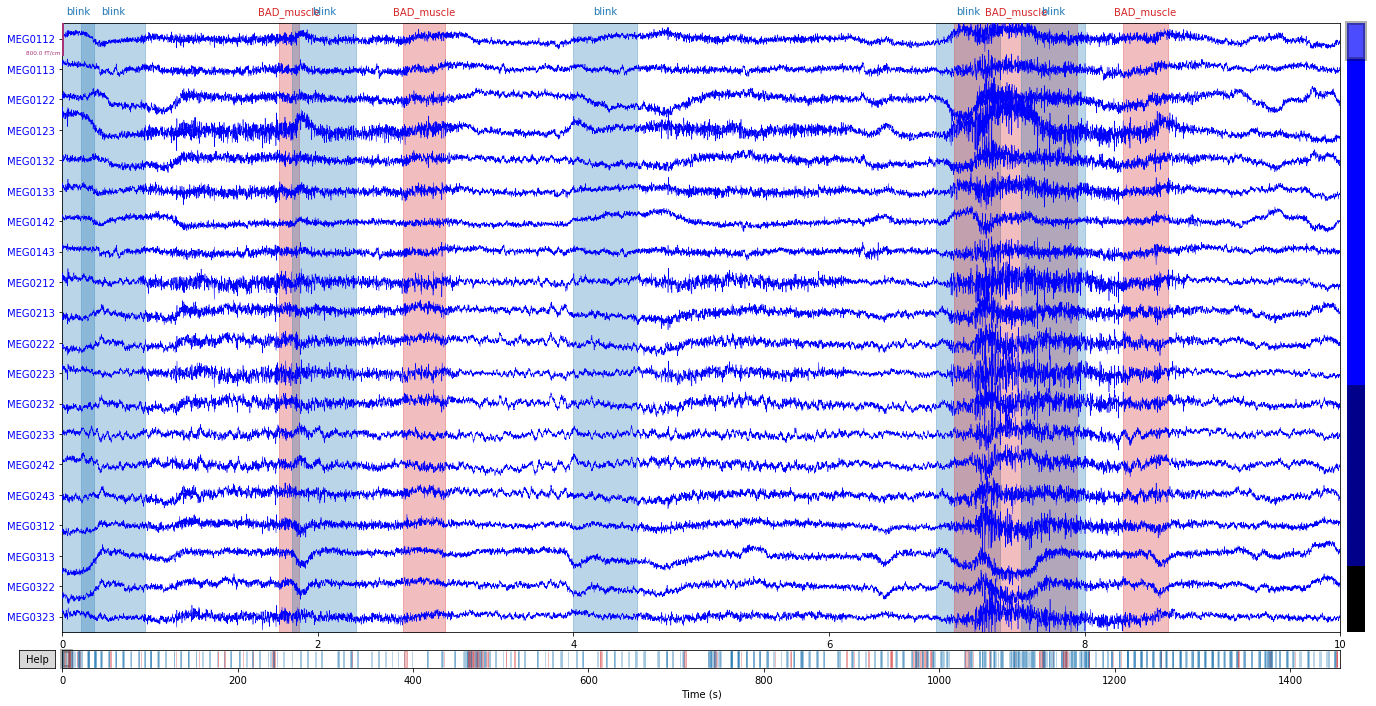

In [10]:
data1.plot();

To specifically inspect the ocular artefacts dislay the EOG sensors: 

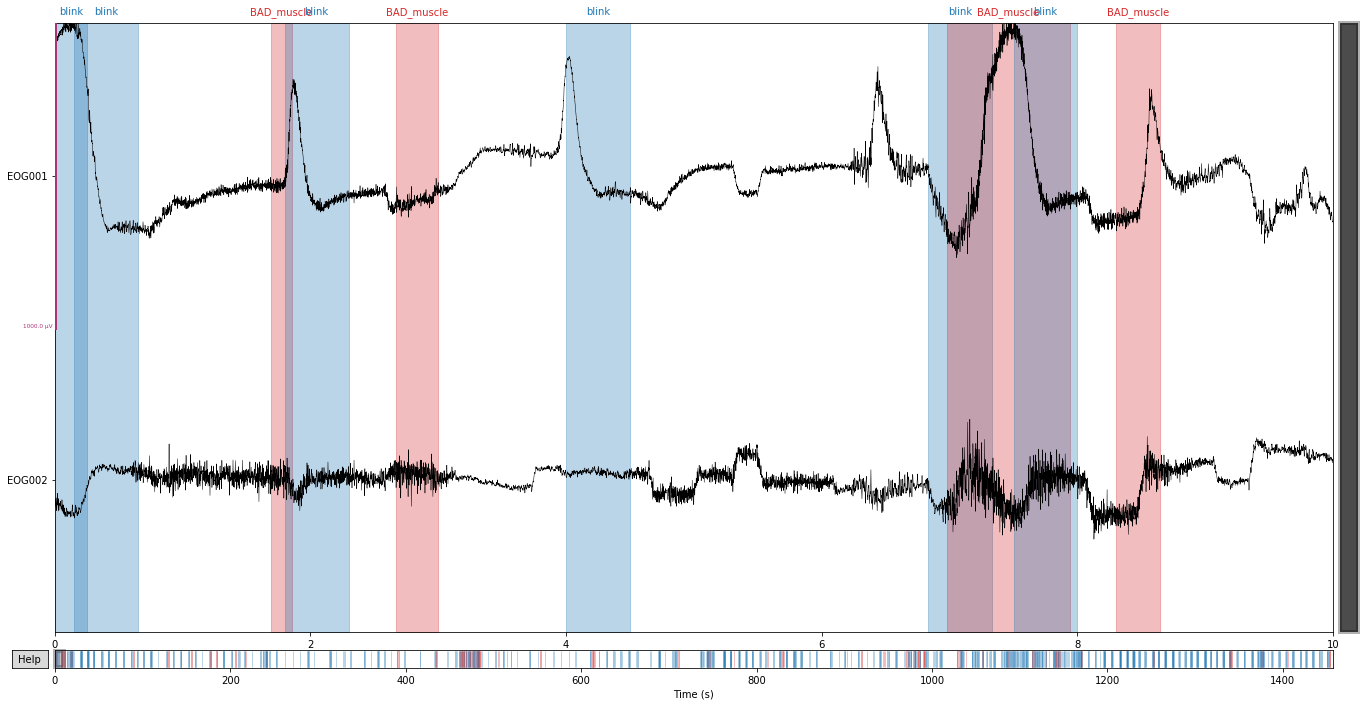

In [7]:
data1.set_channel_types({'EOG001': 'eog'})
data1.set_channel_types({'EOG002': 'eog'})

eog_picks = mne.pick_types(data1.info, meg=False, eog=True)

scl = dict( eog=500e-6)
data1.plot(order = eog_picks, scalings = scl);

## Safe the artefact annotations

Save the data to a FIF-file to be used in the subsequent sections:

In [8]:
path_file_results = os.path.join(result_path,'training_rawann-1.fif') 
path_file_results
data1.save(path_file_results,overwrite=True) 

Writing D:\FLUX\results\training_rawann-1.fif


<ipython-input-8-731db7207489>:3: RuntimeWarning: This filename (D:\FLUX\results\training_rawann-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data1.save(path_file_results,overwrite=True)


Closing D:\FLUX\results\training_rawann-1.fif
[done]


## Perform the annocations in the rest of the dataset 

Now perform the annotation operations to the reset of the FIF-file:

In [9]:
path_data = os.path.join(data_path,file_name[1]) 
data2 = mne.io.read_raw_fif(path_data,preload=True)

# Blinks
eog_events = mne.preprocessing.find_eog_events(data2,ch_name = 'EOG001') 
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / data1.info['sfreq'] - 0.25
onset -= data1._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
annotations_blink = mne.Annotations(onset,duration,description)

annotations_sacc = mne.Annotations(onset,duration,description)

# Muscle
data2filt = data2.copy().notch_filter([50, 100])
threshold_muscle = 5  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    data2, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

# Annotate
data2.set_annotations(annotations_blink+annotations_muscle)  

# Save FIF
path_file_results = os.path.join(result_path,'training_rawann-2.fif') 
path_file_results
data2.save(path_file_results,overwrite=True) 


Opening raw data file D:\FLUX\results\training_rawsss-2.fif...


<ipython-input-9-aed3ce59eb3c>:2: RuntimeWarning: This filename (D:\FLUX\results\training_rawsss-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data2 = mne.io.read_raw_fif(path_data,preload=True)


    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 487 significant peaks
Number of EOG events detected: 487
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

C:\ProgramData\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)

Writing D:\FLUX\results\training_rawann-2.fif


<ipython-input-9-aed3ce59eb3c>:23: RuntimeWarning: Omitted 487 annotation(s) that were outside data range.
  data2.set_annotations(annotations_blink+annotations_muscle)
<ipython-input-9-aed3ce59eb3c>:28: RuntimeWarning: This filename (D:\FLUX\results\training_rawann-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data2.save(path_file_results,overwrite=True)


Closing D:\FLUX\results\training_rawann-2.fif
[done]


## Pregistration and publication

Preregistration: report the the type of artefacts being annotated and well ass the threshold selections. 


Publication, example:

"Artefacts were annotated in the raw data such that they later could be used to reject trials if relevant. Ocular artefacts were identified in the vertical EOG data (bandpass filtered at 1 - 10 Hz) according to segments exceeding a threshold defined according to (max(EOG) - min(EOG))/4. Ocular artefacts were consired 500 ms long centered around the time they exceeded the threshold. Muscle artefacts were identified in magnetometers data bandpass filtered at 110 - 140 Hz. The filtered data were z-scored and segments exceeding a z-score of 10 were annotated as muscle artefacts. " 

## References 

Suresh Muthukumaraswamy. High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138, 2013.
